# Inicjalizacja

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import db
import metrics
import smells
from definitions import Repository
from evaluator import evaluate, calc_impact, create_functions_in_db

#plots size in inches
plt.rcParams["figure.figsize"] = (10,5)

In [8]:
from configuration import ProjectConfiguration

config = ProjectConfiguration()

db.prepare(config.connstr)

dbsession = db.get_session()
create_functions_in_db(dbsession)

# Ewaluacja

In [11]:
repo = config.project

if dbsession.query(Repository).filter(Repository.full_name == repo).first() is None:
    raise LookupError("Repository does not exist")

## Udział smelly prs wśród badanych prs (reprodukcja)

In [12]:
smells_evaluations = [
    evaluate(repo, smells.lack_of_review),
    evaluate(repo, smells.missing_description),
    evaluate(repo, smells.large_changesets),
    evaluate(repo, smells.sleeping_reviews),
    evaluate(repo, smells.review_buddies),
    evaluate(repo, smells.ping_pong),
    evaluate(repo, smells.union,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong]),
    evaluate(repo, smells.intersection,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong])
]

In [13]:
# display results as a text
for evaluation in smells_evaluations:
    print(evaluation)

Lack of code review           	22.71%
Missing PR description        	12.78%
Large changeset               	10.70%
Sleeping reviews              	60.01%
Review Buddies                	9.63%
Ping-pong reviews             	15.37%
At least one of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	80.02%
All of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	0.00%


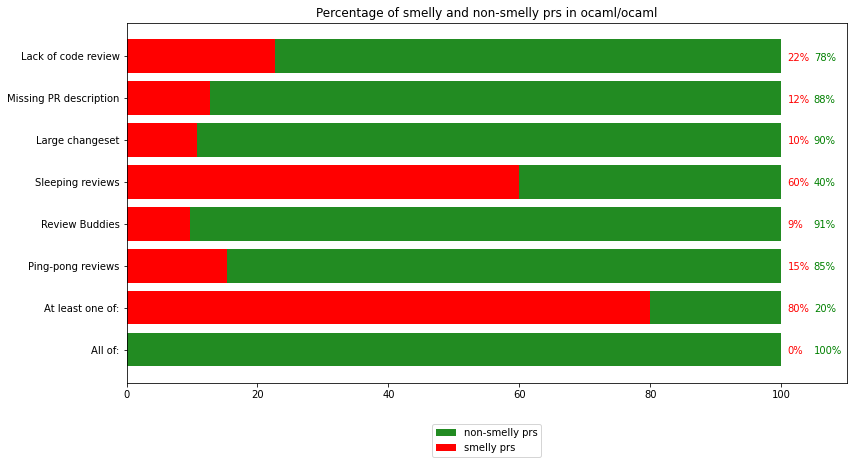

In [14]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e.evaluator_name.split("\n")[0], smells_evaluations))
ys = list(map(lambda e: e.percentage*100, smells_evaluations))
ax.barh(xs, 100, color="forestgreen", label="non-smelly prs")
ax.barh(xs, ys, color="red", label="smelly prs")
for i, v in enumerate(ys):
    ax.text(101, i + 0.1, f"{int(v)}%", color="red")
    ax.text(105, i + 0.1, f"{100-int(v)}%", color="green")
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of smelly and non-smelly prs in {repo}")
plt.margins(x=0.1)
plt.show()

## Wpływ smelli na prawdopodobieństwo wprowadzenia błędu

In [15]:
# evaluate for smells impact
impact_evaluations = list(map(lambda pair: (pair[0], calc_impact(session = dbsession,
                                                                 repo = dbsession.query(Repository).filter(Repository.full_name == repo).first(),
                                                                 evaluator = pair[1],
                                                                 evaluator_args=None)), [
    ("Lack of code review", smells.lack_of_review),
    ("Missing PR description", smells.missing_description),
    ("Large changeset", smells.large_changesets),
    ("Sleeping reviews", smells.sleeping_reviews),
    ("Review Buddies", smells.review_buddies),
    ("Ping-pong reviews", smells.ping_pong)
]))

In [17]:
# display results as text
print(
    f"Percentage of pulls where at least one file was changed next by bug solving PR:")
print(f"{''.ljust(30)}OK    \t SMELLY\t IMPACT")

for (name, res) in impact_evaluations:
    print(f"{name.ljust(30)}{(res[0] * 100):.2f}%\t {(res[1] * 100):.2f}%\t {'+' if res[1]>res[0] else ''}{((res[1]-res[0]) * 100):.2f}%")

Percentage of pulls where at least one file was changed next by bug solving PR:
                              OK    	 SMELLY	 IMPACT
Lack of code review           78.43%	 69.86%	 -8.57%
Missing PR description        78.77%	 60.91%	 -17.85%
Large changeset               74.43%	 93.64%	 +19.21%
Sleeping reviews              68.53%	 81.78%	 +13.25%
Review Buddies                80.76%	 36.36%	 -44.40%
Ping-pong reviews             73.94%	 90.51%	 +16.57%


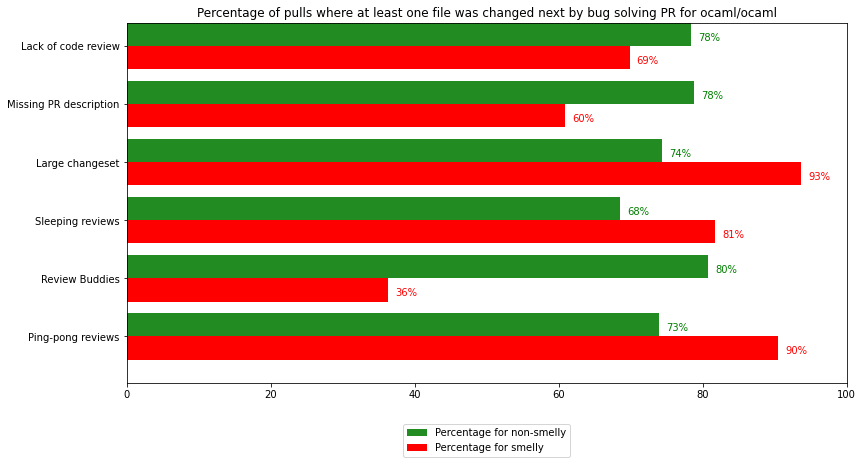

In [18]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e[0], impact_evaluations))
for_ok = list(map(lambda e: e[1][0]*100, impact_evaluations))
for_smelly = list(map(lambda e: e[1][1]*100, impact_evaluations))
ind = np.arange(len(xs))
width = 0.4

ax.barh(ind, for_ok, width, color="forestgreen", label="Percentage for non-smelly")
for i, v in enumerate(for_ok):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + 0.1, f"{int(v)}%" if v==v else "no prs",  color=("green" if v<95 else "black"))
ax.barh(ind + width, for_smelly, width, color="red", label="Percentage for smelly")
for i, v in enumerate(for_smelly):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + width + 0.1, f"{int(v)}%" if v==v else "no prs", color=("red" if v<95 else "black"))
ax.set(yticks=ind + width/2, yticklabels=xs, ylim=[2*width-1, len(xs)], xlim=[0, 100])
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of pulls where at least one file was changed next by bug solving PR for {repo}")
plt.show()

## Metryki

In [ ]:
from evaluator import get_considered_prs

repo_obj = dbsession.query(Repository).filter(Repository.full_name == repo).first()
prs = get_considered_prs(session = dbsession, repo = repo_obj)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot([
    metrics.review_window_metric(prs, repo_obj).to_list(dbsession),
    metrics.review_window_per_line_metric(prs, repo_obj).to_list(dbsession)],
    showfliers=False, notch=True, vert=False)
plt.figure(figsize=(20,10))
plt.show()

#print(metrics.review_window_metric(prs,repo_obj).to_list(dbsession))

In [ ]:
# display results as a text
for evaluation in smells_evaluations:
    print(evaluation)

In [ ]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e.evaluator_name.split("\n")[0], smells_evaluations))
ys = list(map(lambda e: e.percentage*100, smells_evaluations))
ax.barh(xs, 100, color="forestgreen", label="non-smelly prs")
ax.barh(xs, ys, color="red", label="smelly prs")
for i, v in enumerate(ys):
    ax.text(101, i + 0.1, f"{int(v)}%", color="red")
    ax.text(105, i + 0.1, f"{100-int(v)}%", color="green")
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of smelly and non-smelly prs in {repo}")
plt.margins(x=0.1)
plt.show()

## Wpływ smelli na prawdopodobieństwo wprowadzenia błędu

In [ ]:
# evaluate for smells impact
impact_evaluations = list(map(lambda pair: (pair[0], calc_impact(session = dbsession,
                                                                 repo = dbsession.query(Repository).filter(Repository.full_name == repo).first(),
                                                                 evaluator = pair[1],
                                                                 evaluator_args=None)), [
    ("Lack of code review", smells.lack_of_review),
    ("Missing PR description", smells.missing_description),
    ("Large changeset", smells.large_changesets),
    ("Sleeping reviews", smells.sleeping_reviews),
    ("Review Buddies", smells.review_buddies),
    ("Ping-pong reviews", smells.ping_pong)
]))

In [ ]:
# display results as text
print(
    f"Percentage of pulls where at least one file was changed next by bug solving PR:")
print(f"{''.ljust(30)}OK    \t SMELLY\t IMPACT")

for (name, res) in impact_evaluations:
    print(f"{name.ljust(30)}{(res[0] * 100):.2f}%\t {(res[1] * 100):.2f}%\t {'+' if res[1]>res[0] else ''}{((res[1]-res[0]) * 100):.2f}%")

In [ ]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e[0], impact_evaluations))
for_ok = list(map(lambda e: e[1][0]*100, impact_evaluations))
for_smelly = list(map(lambda e: e[1][1]*100, impact_evaluations))
ind = np.arange(len(xs))
width = 0.4

ax.barh(ind, for_ok, width, color="forestgreen", label="Percentage for non-smelly")
for i, v in enumerate(for_ok):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + 0.1, f"{int(v)}%" if v==v else "no prs",  color=("green" if v<95 else "black"))
ax.barh(ind + width, for_smelly, width, color="red", label="Percentage for smelly")
for i, v in enumerate(for_smelly):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + width + 0.1, f"{int(v)}%" if v==v else "no prs", color=("red" if v<95 else "black"))
ax.set(yticks=ind + width/2, yticklabels=xs, ylim=[2*width-1, len(xs)], xlim=[0, 100])
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of pulls where at least one file was changed next by bug solving PR for {repo}")
plt.show()

## Metryki

In [ ]:
from sqlalchemy import column, select
from evaluator import get_considered_prs

repo_obj = dbsession.query(Repository).filter(Repository.full_name == repo).first()
prs = get_considered_prs(session = dbsession, repo = repo_obj)

def get_metric_res_as_list(metric: callable):
    result = metric(prs, repo_obj)
    return list(map(lambda r: float(r[0]),dbsession.execute(select(column(result.metrics_names[0])).select_from(result.evaluated.subquery())).all()))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot([get_metric_res_as_list(metrics.review_window_metric),get_metric_res_as_list(metrics.review_window_per_line_metric)], showfliers=False, notch=True, vert=False)
plt.figure(figsize=(20,10))
plt.show()